# Forex Momentum Analysis

## Obiettivo
Questo notebook esplora l'esistenza del fenomeno di momentum sui mercati forex, testando diverse combinazioni di lookback periods sui dati delle coppie valutarie per identificare:

1. **Se il momentum esiste nel forex**
2. **Su quali valute è più pronunciato**
3. **Qual è il periodo di lookback ottimale**

## Dataset
31 coppie valutarie con dati storici dal 2000-2025 (25+ anni)

---
## 1. Setup & Importazioni

In [24]:
# Importazioni base
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Importazioni modulo momentum strategy
from momentum_strategy import (
    load_all_data, 
    calculate_monthly_returns,
    calculate_momentum_signals,
    select_top_quantile,
    backtest_strategy,
    calculate_performance_metrics
)

# Configurazione grafici
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("✅ Setup completato")

✅ Setup completato


---
## 2. Caricamento Dati Forex

In [25]:
# Caricamento dati forex
print("📊 Caricamento dati forex...")
forex_data = load_all_data('../data/forex')  # Fixed path: go up one level from notebooks/

print(f"📈 Dati forex caricati:")
print(f"   Shape: {forex_data.shape}")

# Fix per gestire index vuoti o con NaT values
if len(forex_data) > 0 and not forex_data.index.empty:
    # Rimuovi NaT values se presenti
    valid_index = forex_data.index.dropna()
    if len(valid_index) > 0:
        print(f"   Date range: {valid_index.min().strftime('%Y-%m-%d')} to {valid_index.max().strftime('%Y-%m-%d')}")
    else:
        print("   Date range: No valid dates found")
else:
    print("   Date range: Dataset vuoto")

print(f"   Currency pairs: {len(forex_data.columns)}")

# Mostra le coppie disponibili solo se ci sono dati
if len(forex_data.columns) > 0:
    print("\n💱 Coppie valutarie disponibili:")
    pairs_list = sorted(forex_data.columns)
    for i in range(0, len(pairs_list), 4):  # 4 colonne
        row = pairs_list[i:i+4]
        print("   " + " ".join(f"{pair:<12}" for pair in row))
else:
    print("\n❌ Nessuna coppia valutaria trovata - verifica il path dei dati")

📊 Caricamento dati forex...
📈 Dati forex caricati:
   Shape: (6678, 31)
   Date range: 2000-01-03 to 2025-08-15
   Currency pairs: 31

💱 Coppie valutarie disponibili:
   AUDCAD_X     AUDJPY_X     AUDNZD_X     AUDUSD_X    
   CADCHF_X     CADJPY_X     CHFJPY_X     EURAUD_X    
   EURCAD_X     EURCHF_X     EURGBP_X     EURJPY_X    
   EURNZD_X     EURUSD_X     GBPAUD_X     GBPCAD_X    
   GBPCHF_X     GBPJPY_X     GBPNZD_X     GBPUSD_X    
   NZDCHF_X     NZDJPY_X     NZDUSD_X     USDCAD_X    
   USDCHF_X     USDHKD_X     USDJPY_X     USDMXN_X    
   USDNOK_X     USDSEK_X     USDZAR_X    


In [26]:
# Calcolo rendimenti mensili
print("🔄 Calcolo rendimenti mensili...")
monthly_returns = calculate_monthly_returns(forex_data)

print(f"\n📊 Rendimenti mensili:")
print(f"   Shape: {monthly_returns.shape}")
print(f"   Date range: {monthly_returns.index.min().strftime('%Y-%m')} to {monthly_returns.index.max().strftime('%Y-%m')}")
print(f"   Total months: {len(monthly_returns)}")

# Filtro per coppie con dati sufficienti (min 5 anni)
min_observations = 60
valid_pairs = monthly_returns.dropna().columns[monthly_returns.dropna().count() >= min_observations]
monthly_returns = monthly_returns[valid_pairs]

print(f"\n✅ Dopo filtro (min 5 anni): {len(valid_pairs)} coppie valide")

🔄 Calcolo rendimenti mensili...

📊 Rendimenti mensili:
   Shape: (308, 31)
   Date range: 2000-01 to 2025-08
   Total months: 308

✅ Dopo filtro (min 5 anni): 31 coppie valide


---
## 3. Esplorazione Dati

In [27]:
# Analisi esposizione valutarie
base_currencies = {}
quote_currencies = {}

for pair in valid_pairs:
    clean_pair = pair.replace('_X', '')
    if len(clean_pair) == 6:
        base = clean_pair[:3]
        quote = clean_pair[3:]
        base_currencies[base] = base_currencies.get(base, 0) + 1
        quote_currencies[quote] = quote_currencies.get(quote, 0) + 1

print("💰 Esposizione Base Currency:")
for curr, count in sorted(base_currencies.items(), key=lambda x: x[1], reverse=True):
    print(f"   {curr}: {count} pairs")

print("\n💰 Esposizione Quote Currency:")
for curr, count in sorted(quote_currencies.items(), key=lambda x: x[1], reverse=True):
    print(f"   {curr}: {count} pairs")

💰 Esposizione Base Currency:
   USD: 8 pairs
   EUR: 7 pairs
   GBP: 6 pairs
   AUD: 4 pairs
   NZD: 3 pairs
   CAD: 2 pairs
   CHF: 1 pairs

💰 Esposizione Quote Currency:
   JPY: 7 pairs
   CHF: 5 pairs
   CAD: 4 pairs
   USD: 4 pairs
   NZD: 3 pairs
   AUD: 2 pairs
   SEK: 1 pairs
   HKD: 1 pairs
   ZAR: 1 pairs
   GBP: 1 pairs
   NOK: 1 pairs
   MXN: 1 pairs


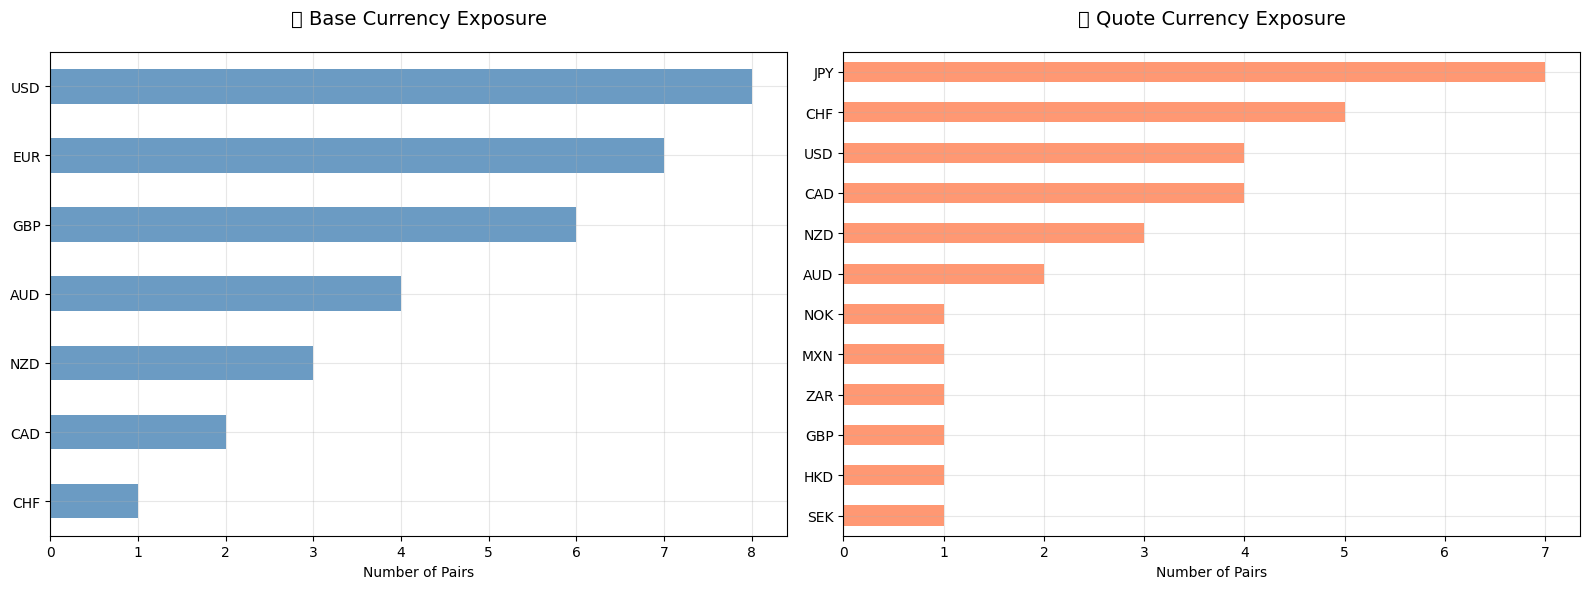

In [28]:
# Visualizzazione esposizione valutarie
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Base currencies
base_df = pd.Series(base_currencies).sort_values(ascending=True)
base_df.plot(kind='barh', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('📈 Base Currency Exposure', fontsize=14, pad=20)
ax1.set_xlabel('Number of Pairs')
ax1.grid(True, alpha=0.3)

# Quote currencies
quote_df = pd.Series(quote_currencies).sort_values(ascending=True)
quote_df.plot(kind='barh', ax=ax2, color='coral', alpha=0.8)
ax2.set_title('📉 Quote Currency Exposure', fontsize=14, pad=20)
ax2.set_xlabel('Number of Pairs')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Statistiche descrittive sui rendimenti
print("📊 Statistiche Rendimenti Mensili:")
print("=" * 50)

stats_df = monthly_returns.describe().T
stats_df['Annualized_Return'] = stats_df['mean'] * 12
stats_df['Annualized_Vol'] = stats_df['std'] * np.sqrt(12)
stats_df['Sharpe_Ratio'] = stats_df['Annualized_Return'] / stats_df['Annualized_Vol']

display_stats = stats_df[['mean', 'std', 'Annualized_Return', 'Annualized_Vol', 'Sharpe_Ratio']].round(4)
display_stats = display_stats.sort_values('Annualized_Return', ascending=False)

# Mostra top 10 e bottom 5
print("\n🏆 Top 10 Performance:")
print(display_stats.head(10))

print("\n📉 Bottom 5 Performance:")
print(display_stats.tail(5))

📊 Statistiche Rendimenti Mensili:

🏆 Top 10 Performance:
            mean     std  Annualized_Return  Annualized_Vol  Sharpe_Ratio
USDZAR_X  0.0048  0.0465             0.0575          0.1611        0.3568
CHFJPY_X  0.0033  0.0282             0.0392          0.0978        0.4008
USDMXN_X  0.0026  0.0347             0.0309          0.1200        0.2572
NZDJPY_X  0.0016  0.0391             0.0191          0.1355        0.1412
CADJPY_X  0.0016  0.0338             0.0187          0.1169        0.1601
EURJPY_X  0.0015  0.0301             0.0183          0.1044        0.1754
EURGBP_X  0.0014  0.0217             0.0170          0.0751        0.2259
USDJPY_X  0.0014  0.0272             0.0168          0.0942        0.1782
AUDJPY_X  0.0014  0.0377             0.0167          0.1304        0.1277
USDNOK_X  0.0010  0.0336             0.0114          0.1165        0.0980

📉 Bottom 5 Performance:
            mean     std  Annualized_Return  Annualized_Vol  Sharpe_Ratio
GBPUSD_X -0.0008  0.0249      

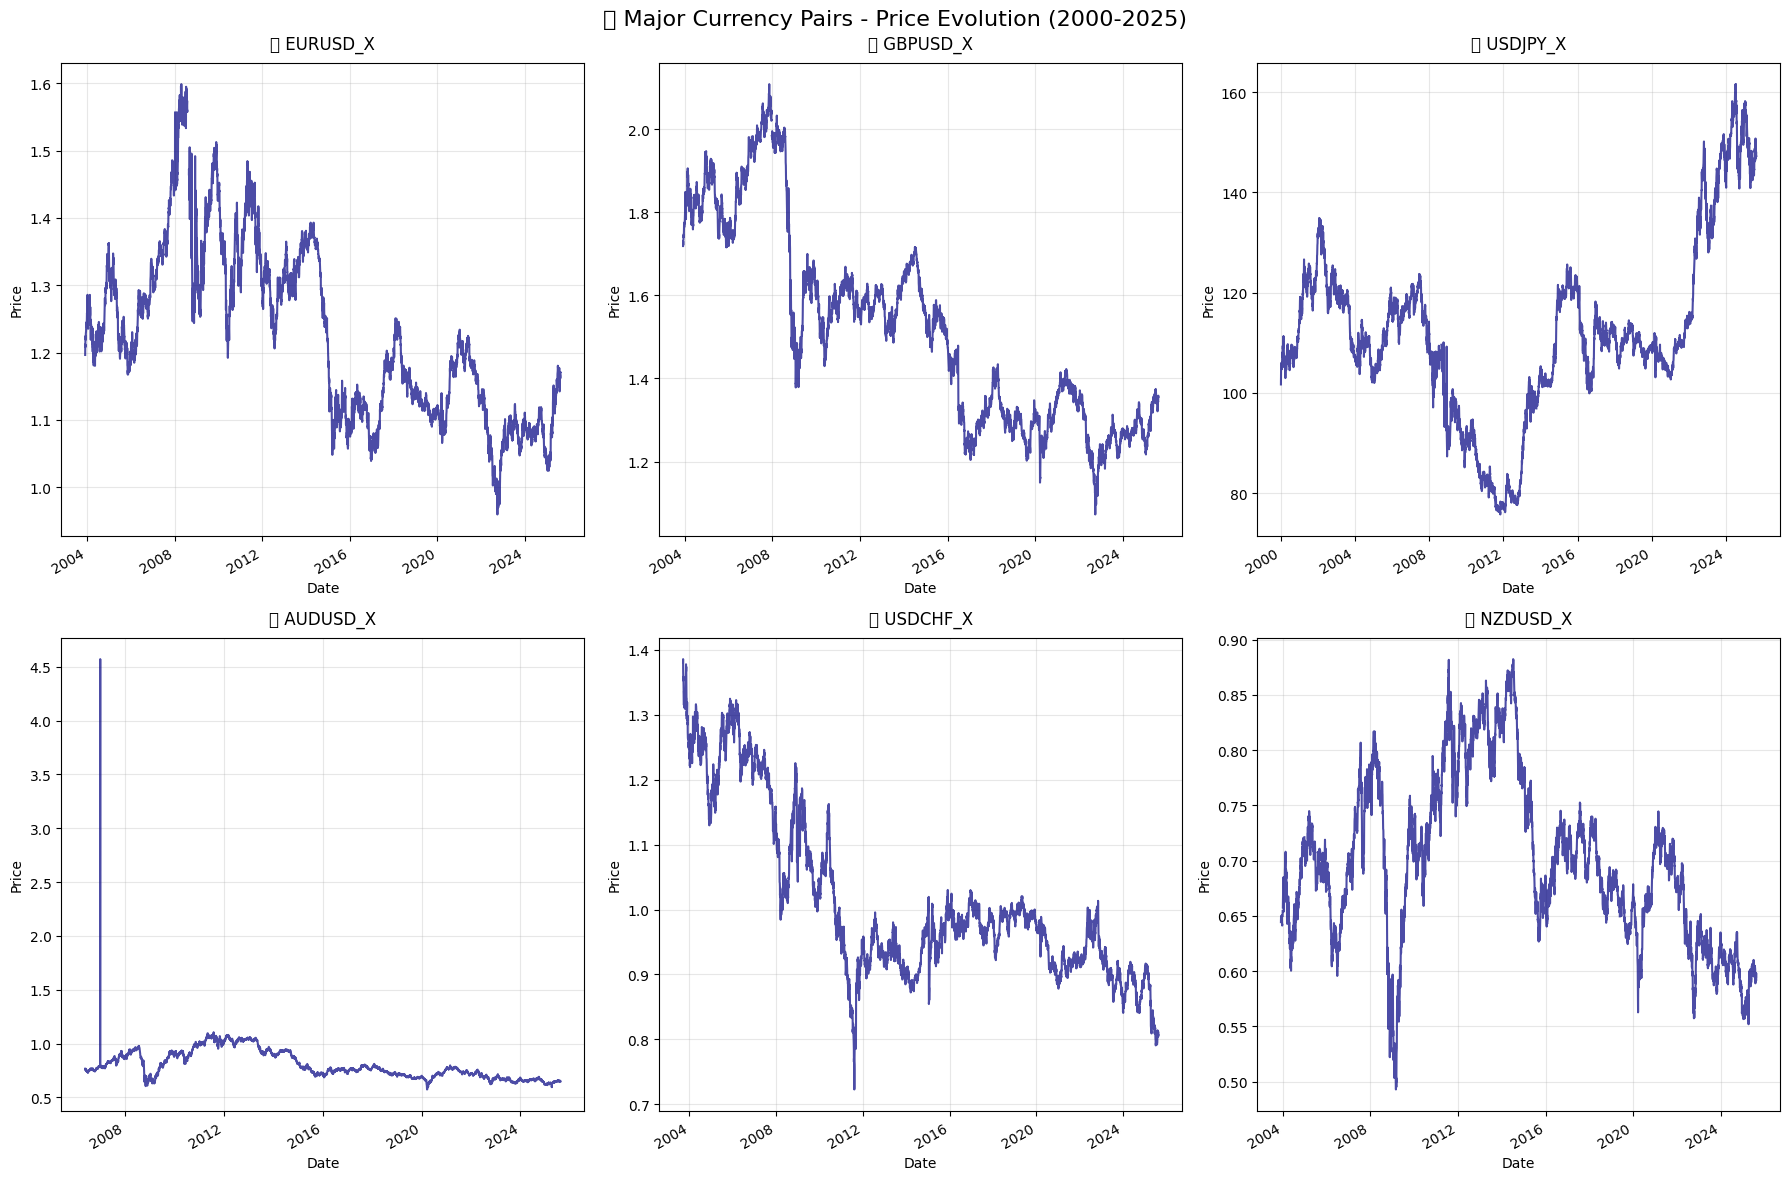

In [30]:
# Visualizzazione evoluzione prezzi major pairs
major_pairs = ['EURUSD_X', 'GBPUSD_X', 'USDJPY_X', 'AUDUSD_X', 'USDCHF_X', 'NZDUSD_X']
available_majors = [pair for pair in major_pairs if pair in forex_data.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, pair in enumerate(available_majors):
    if i < len(axes):
        forex_data[pair].plot(ax=axes[i], color='navy', alpha=0.7, linewidth=1.5)
        axes[i].set_title(f'💱 {pair}', fontsize=12, pad=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylabel('Price')

# Nascondi subplot non utilizzati
for i in range(len(available_majors), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('📊 Major Currency Pairs - Price Evolution (2000-2025)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

---
## 4. Test Momentum Strategy

In [31]:
# Configurazione test momentum
lookback_periods = [1, 3, 6, 9, 12, 18, 24, 36]
top_quantile = 0.1  # Top quartile selection

print("🚀 Avvio test momentum strategy")
print(f"   Lookback periods da testare: {lookback_periods}")
print(f"   Selezione top: {top_quantile:.1%} (top quartile)")
print(f"   Coppie valutarie: {len(valid_pairs)}")
print("\n" + "="*60)

# Storage per risultati
results = {}
performance_summary = []

🚀 Avvio test momentum strategy
   Lookback periods da testare: [1, 3, 6, 9, 12, 18, 24, 36]
   Selezione top: 10.0% (top quartile)
   Coppie valutarie: 31



In [32]:
# Esecuzione test per ogni lookback period
for lookback in lookback_periods:
    print(f"\n⏳ Testing {lookback}-month lookback...")
    
    # Calcola segnali momentum
    momentum_signals = calculate_momentum_signals(monthly_returns, lookback_months=lookback)
    
    # Seleziona top performers con risk parity weights
    weights = select_top_quantile(momentum_signals, monthly_returns, quantile=top_quantile)
    
    # Backtest strategy
    portfolio_returns, portfolio_cumulative = backtest_strategy(forex_data, weights)
    
    # Calcola metriche performance
    metrics = calculate_performance_metrics(portfolio_returns)
    
    # Salva risultati
    results[lookback] = {
        'momentum_signals': momentum_signals,
        'weights': weights,
        'portfolio_returns': portfolio_returns,
        'portfolio_cumulative': portfolio_cumulative,
        'metrics': metrics
    }
    
    # Crea summary performance
    perf_row = {
        'Lookback_Months': lookback,
        'Total_Return': metrics['Total Return'],
        'Annualized_Return': metrics['Annualized Return'],
        'Volatility': metrics['Volatility'],
        'Sharpe_Ratio': metrics['Sharpe Ratio'],
        'Max_Drawdown': metrics['Max Drawdown'],
        'Positive_Months': metrics['Positive Months'],
        'Best_Month': metrics['Best Month'],
        'Worst_Month': metrics['Worst Month']
    }
    performance_summary.append(perf_row)
    
    # Output risultati immediati
    print(f"   ✅ Annualized Return: {metrics['Annualized Return']:.2%}")
    print(f"   📊 Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
    print(f"   📉 Max Drawdown: {metrics['Max Drawdown']:.2%}")

print("\n🎉 Test momentum completati!")


⏳ Testing 1-month lookback...
   ✅ Annualized Return: -1.43%
   📊 Sharpe Ratio: -0.150
   📉 Max Drawdown: -48.84%

⏳ Testing 3-month lookback...
   ✅ Annualized Return: -0.26%
   📊 Sharpe Ratio: -0.028
   📉 Max Drawdown: -34.36%

⏳ Testing 6-month lookback...
   ✅ Annualized Return: -0.45%
   📊 Sharpe Ratio: -0.049
   📉 Max Drawdown: -29.76%

⏳ Testing 9-month lookback...
   ✅ Annualized Return: 1.25%
   📊 Sharpe Ratio: 0.139
   📉 Max Drawdown: -22.89%

⏳ Testing 12-month lookback...
   ✅ Annualized Return: -0.43%
   📊 Sharpe Ratio: -0.047
   📉 Max Drawdown: -42.37%

⏳ Testing 18-month lookback...
   ✅ Annualized Return: 0.31%
   📊 Sharpe Ratio: 0.036
   📉 Max Drawdown: -31.87%

⏳ Testing 24-month lookback...
   ✅ Annualized Return: -0.34%
   📊 Sharpe Ratio: -0.040
   📉 Max Drawdown: -29.81%

⏳ Testing 36-month lookback...
   ✅ Annualized Return: -0.11%
   📊 Sharpe Ratio: -0.012
   📉 Max Drawdown: -35.18%

🎉 Test momentum completati!


---
## 5. Analisi Risultati

In [33]:
# Summary performance per lookback period
performance_df = pd.DataFrame(performance_summary)
performance_df = performance_df.set_index('Lookback_Months')

print("📊 PERFORMANCE SUMMARY BY LOOKBACK PERIOD")
print("=" * 60)
print(performance_df.round(4))

# Identifica best performers
best_sharpe = performance_df.loc[performance_df['Sharpe_Ratio'].idxmax()]
best_return = performance_df.loc[performance_df['Annualized_Return'].idxmax()]

print(f"\n🏆 MIGLIORI PERFORMANCE:")
print(f"   Best Sharpe Ratio: {best_sharpe.name} months ({best_sharpe['Sharpe_Ratio']:.3f})")
print(f"   Best Annualized Return: {best_return.name} months ({best_return['Annualized_Return']:.2%})")

📊 PERFORMANCE SUMMARY BY LOOKBACK PERIOD
                 Total_Return  Annualized_Return  Volatility  Sharpe_Ratio  \
Lookback_Months                                                              
1                     -0.3088            -0.0143      0.0956       -0.1495   
3                     -0.0641            -0.0026      0.0917       -0.0281   
6                     -0.1092            -0.0045      0.0921       -0.0488   
9                      0.3755             0.0125      0.0897        0.1393   
12                    -0.1045            -0.0043      0.0920       -0.0466   
18                     0.0819             0.0031      0.0855        0.0359   
24                    -0.0827            -0.0034      0.0835       -0.0402   
36                    -0.0266            -0.0011      0.0846       -0.0124   

                 Max_Drawdown  Positive_Months  Best_Month  Worst_Month  
Lookback_Months                                                          
1                     -0.4884 

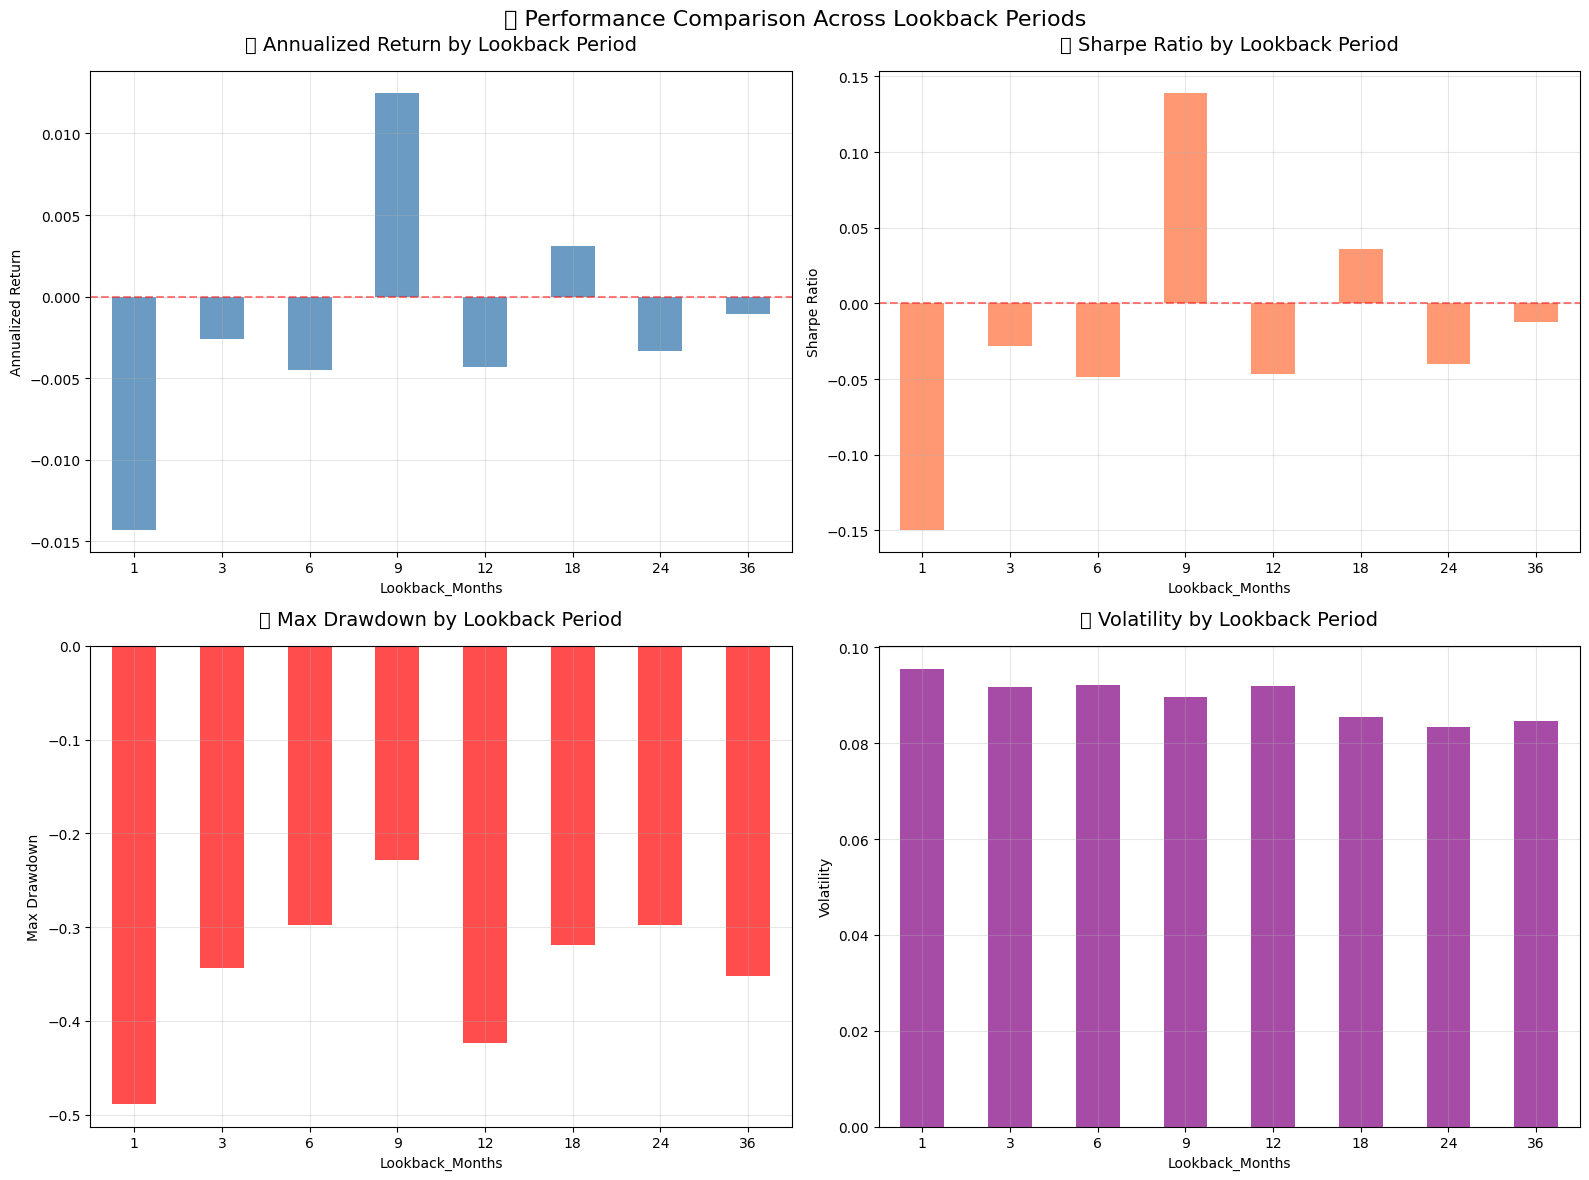

In [34]:
# Visualizzazione comparativa performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Annualized Return by Lookback
performance_df['Annualized_Return'].plot(kind='bar', ax=axes[0,0], color='steelblue', alpha=0.8)
axes[0,0].set_title('📈 Annualized Return by Lookback Period', fontsize=14, pad=15)
axes[0,0].set_ylabel('Annualized Return')
axes[0,0].tick_params(axis='x', rotation=0)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 2. Sharpe Ratio by Lookback
performance_df['Sharpe_Ratio'].plot(kind='bar', ax=axes[0,1], color='coral', alpha=0.8)
axes[0,1].set_title('📊 Sharpe Ratio by Lookback Period', fontsize=14, pad=15)
axes[0,1].set_ylabel('Sharpe Ratio')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Max Drawdown by Lookback
performance_df['Max_Drawdown'].plot(kind='bar', ax=axes[1,0], color='red', alpha=0.7)
axes[1,0].set_title('📉 Max Drawdown by Lookback Period', fontsize=14, pad=15)
axes[1,0].set_ylabel('Max Drawdown')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid(True, alpha=0.3)

# 4. Volatility by Lookback
performance_df['Volatility'].plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('📊 Volatility by Lookback Period', fontsize=14, pad=15)
axes[1,1].set_ylabel('Volatility')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('🎯 Performance Comparison Across Lookback Periods', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

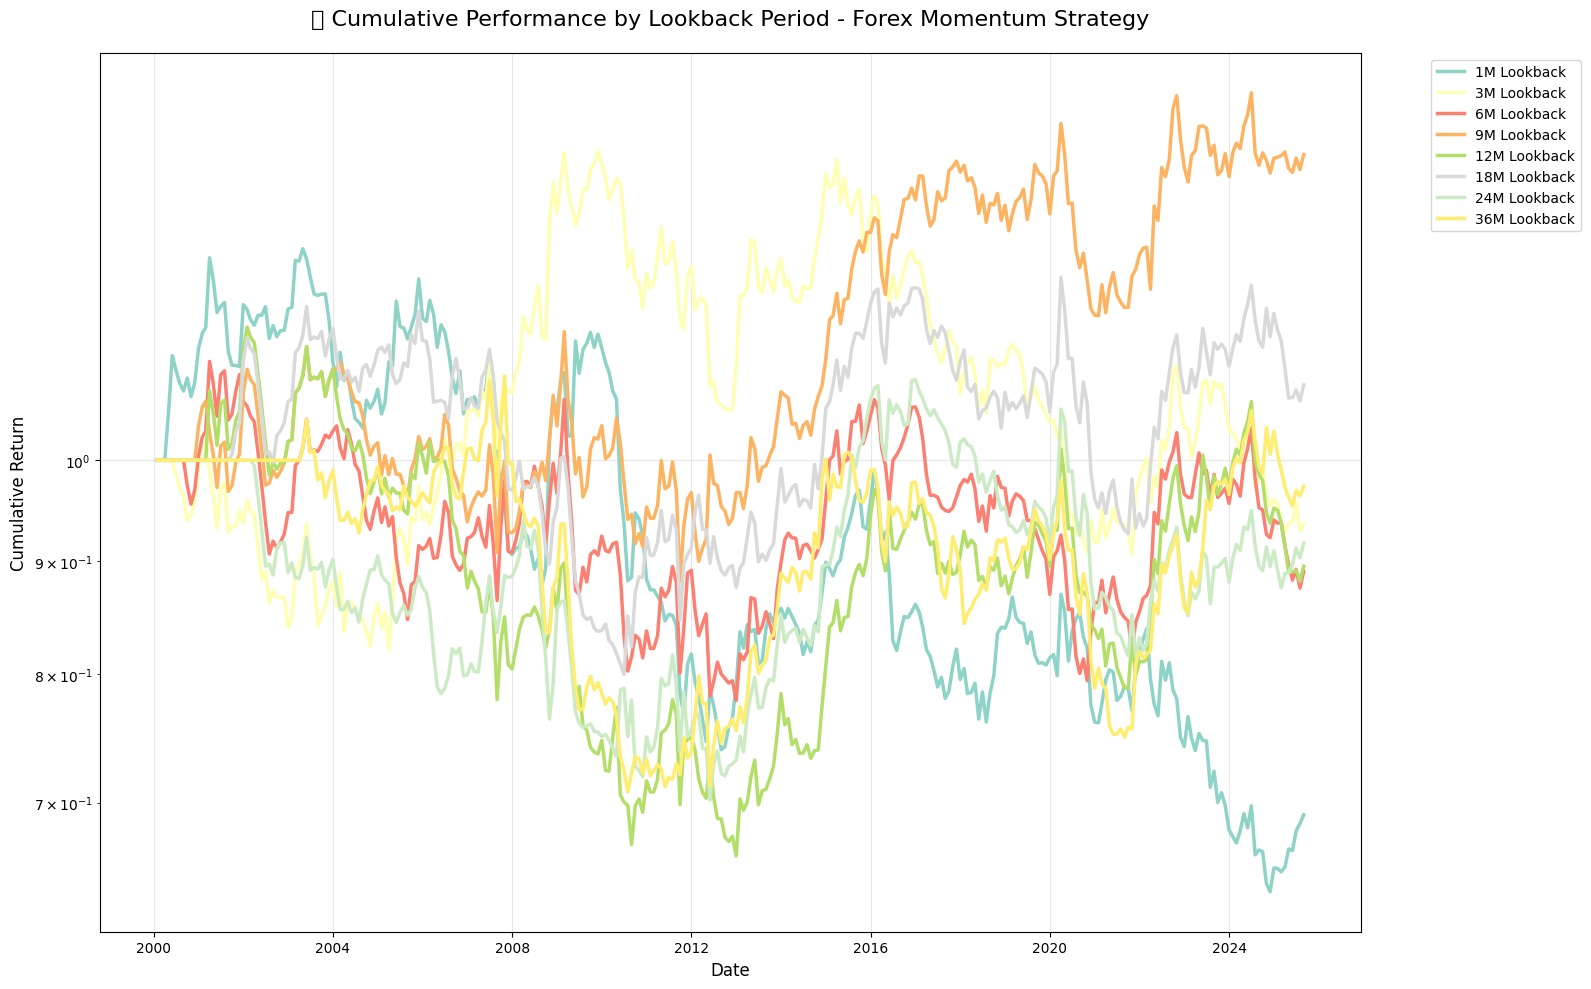


🎯 Buy-and-Hold Benchmark (Equal Weight All Pairs):
   Total Return: 13.48%
   Annualized Return: 0.49%
   Volatility: 3.17%
   Sharpe Ratio: 0.172


In [35]:
# Curva performance cumulativa
plt.figure(figsize=(16, 10))

colors = plt.cm.Set3(np.linspace(0, 1, len(lookback_periods)))

for i, lookback in enumerate(lookback_periods):
    portfolio_cum = results[lookback]['portfolio_cumulative']
    plt.plot(portfolio_cum.index, portfolio_cum, 
             label=f'{lookback}M Lookback', linewidth=2.5, color=colors[i])

plt.title('📈 Cumulative Performance by Lookback Period - Forex Momentum Strategy', 
          fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale per migliore visualizzazione
plt.tight_layout()
plt.show()

# Benchmark buy-and-hold
equal_weight_returns = monthly_returns.mean(axis=1)
equal_weight_cumulative = (1 + equal_weight_returns).cumprod()

print(f"\n🎯 Buy-and-Hold Benchmark (Equal Weight All Pairs):")
print(f"   Total Return: {equal_weight_cumulative.iloc[-1] - 1:.2%}")
print(f"   Annualized Return: {(equal_weight_cumulative.iloc[-1]) ** (12/len(equal_weight_returns)) - 1:.2%}")
print(f"   Volatility: {equal_weight_returns.std() * np.sqrt(12):.2%}")
print(f"   Sharpe Ratio: {(equal_weight_returns.mean() * 12) / (equal_weight_returns.std() * np.sqrt(12)):.3f}")

---
## 6. Analisi Valute Specifiche

In [36]:
# Analisi contributo singole coppie (usando best Sharpe)
best_lookback = performance_df['Sharpe_Ratio'].idxmax()
print(f"🔍 Analisi contributi usando {best_lookback}-month lookback (best Sharpe ratio)")

best_weights = results[best_lookback]['weights']
best_momentum = results[best_lookback]['momentum_signals']

# Calcola pesi medi nel tempo
avg_weights = best_weights.mean().sort_values(ascending=False)

print(f"\n💰 AVERAGE PORTFOLIO WEIGHTS (Top 10):")
print("=" * 45)
for i, (pair, weight) in enumerate(avg_weights.head(10).items(), 1):
    print(f"   {i:2d}. {pair:<12}: {weight:.3f} ({weight:.1%})")

# Analisi momentum scores per coppia
avg_momentum = best_momentum.mean().sort_values(ascending=False)

print(f"\n📊 AVERAGE MOMENTUM SCORES (Top 10):")
print("=" * 45)
for i, (pair, score) in enumerate(avg_momentum.head(10).items(), 1):
    print(f"   {i:2d}. {pair:<12}: {score:+.4f}")

🔍 Analisi contributi usando 9-month lookback (best Sharpe ratio)

💰 AVERAGE PORTFOLIO WEIGHTS (Top 10):
    1. USDJPY_X    : 0.092 (9.2%)
    2. EURGBP_X    : 0.083 (8.3%)
    3. USDSEK_X    : 0.070 (7.0%)
    4. USDNOK_X    : 0.060 (6.0%)
    5. USDZAR_X    : 0.055 (5.5%)
    6. USDMXN_X    : 0.052 (5.2%)
    7. NZDJPY_X    : 0.042 (4.2%)
    8. NZDUSD_X    : 0.041 (4.1%)
    9. CHFJPY_X    : 0.038 (3.8%)
   10. GBPAUD_X    : 0.037 (3.7%)

📊 AVERAGE MOMENTUM SCORES (Top 10):
    1. USDZAR_X    : +0.0441
    2. CHFJPY_X    : +0.0290
    3. USDMXN_X    : +0.0254
    4. NZDJPY_X    : +0.0142
    5. USDJPY_X    : +0.0134
    6. CADJPY_X    : +0.0127
    7. AUDJPY_X    : +0.0123
    8. EURGBP_X    : +0.0115
    9. EURJPY_X    : +0.0114
   10. USDNOK_X    : +0.0111


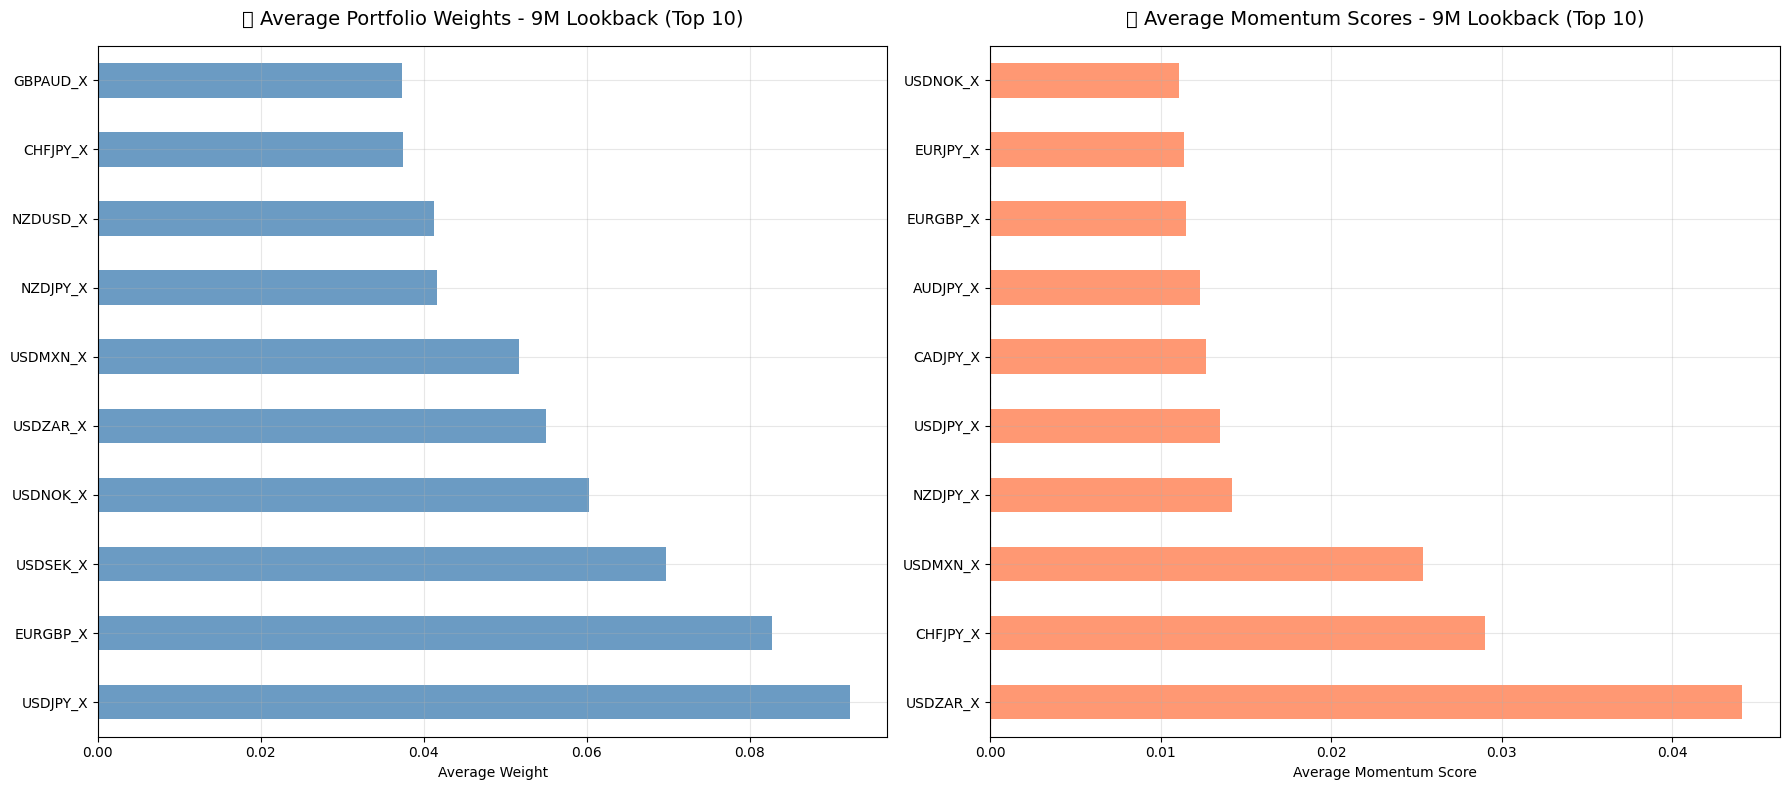

In [37]:
# Visualizzazione contributi principali
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Average weights
avg_weights.head(10).plot(kind='barh', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title(f'💰 Average Portfolio Weights - {best_lookback}M Lookback (Top 10)', 
              fontsize=14, pad=15)
ax1.set_xlabel('Average Weight')
ax1.grid(True, alpha=0.3)

# Average momentum scores
avg_momentum.head(10).plot(kind='barh', ax=ax2, color='coral', alpha=0.8)
ax2.set_title(f'📊 Average Momentum Scores - {best_lookback}M Lookback (Top 10)', 
              fontsize=14, pad=15)
ax2.set_xlabel('Average Momentum Score')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [38]:
# Analisi momentum per valuta individuale
print("💱 CURRENCY-SPECIFIC MOMENTUM ANALYSIS")
print("=" * 50)

currency_momentum = {}
currency_weights = {}

for pair in valid_pairs:
    clean_pair = pair.replace('_X', '')
    if len(clean_pair) == 6:
        base = clean_pair[:3]
        quote = clean_pair[3:]
        
        momentum_score = avg_momentum.get(pair, 0)
        weight = avg_weights.get(pair, 0)
        
        # Base currency
        if base not in currency_momentum:
            currency_momentum[base] = []
            currency_weights[base] = []
        currency_momentum[base].append(momentum_score)
        currency_weights[base].append(weight)
        
        # Quote currency (relazione inversa)
        if quote not in currency_momentum:
            currency_momentum[quote] = []
            currency_weights[quote] = []
        currency_momentum[quote].append(-momentum_score)
        currency_weights[quote].append(weight)

# Calcola medie per valuta
currency_avg_momentum = {curr: np.mean(scores) for curr, scores in currency_momentum.items()}
currency_avg_weights = {curr: np.mean(weights) for curr, weights in currency_weights.items()}

print("\n🏆 AVERAGE MOMENTUM BY CURRENCY (positive = strengthening):")
print("=" * 60)
for curr, momentum in sorted(currency_avg_momentum.items(), key=lambda x: x[1], reverse=True):
    weight = currency_avg_weights[curr]
    status = "🟢" if momentum > 0 else "🔴"
    print(f"   {status} {curr}: {momentum:+.4f} (avg weight: {weight:.3f})")

💱 CURRENCY-SPECIFIC MOMENTUM ANALYSIS

🏆 AVERAGE MOMENTUM BY CURRENCY (positive = strengthening):
   🟢 CHF: +0.0140 (avg weight: 0.020)
   🟢 USD: +0.0084 (avg weight: 0.039)
   🟢 EUR: +0.0019 (avg weight: 0.030)
   🟢 AUD: +0.0014 (avg weight: 0.023)
   🟢 CAD: +0.0006 (avg weight: 0.018)
   🟢 NZD: +0.0004 (avg weight: 0.027)
   🔴 HKD: -0.0000 (avg weight: 0.000)
   🔴 GBP: -0.0042 (avg weight: 0.031)
   🔴 SEK: -0.0045 (avg weight: 0.070)
   🔴 NOK: -0.0111 (avg weight: 0.060)
   🔴 JPY: -0.0141 (avg weight: 0.041)
   🔴 MXN: -0.0254 (avg weight: 0.052)
   🔴 ZAR: -0.0441 (avg weight: 0.055)


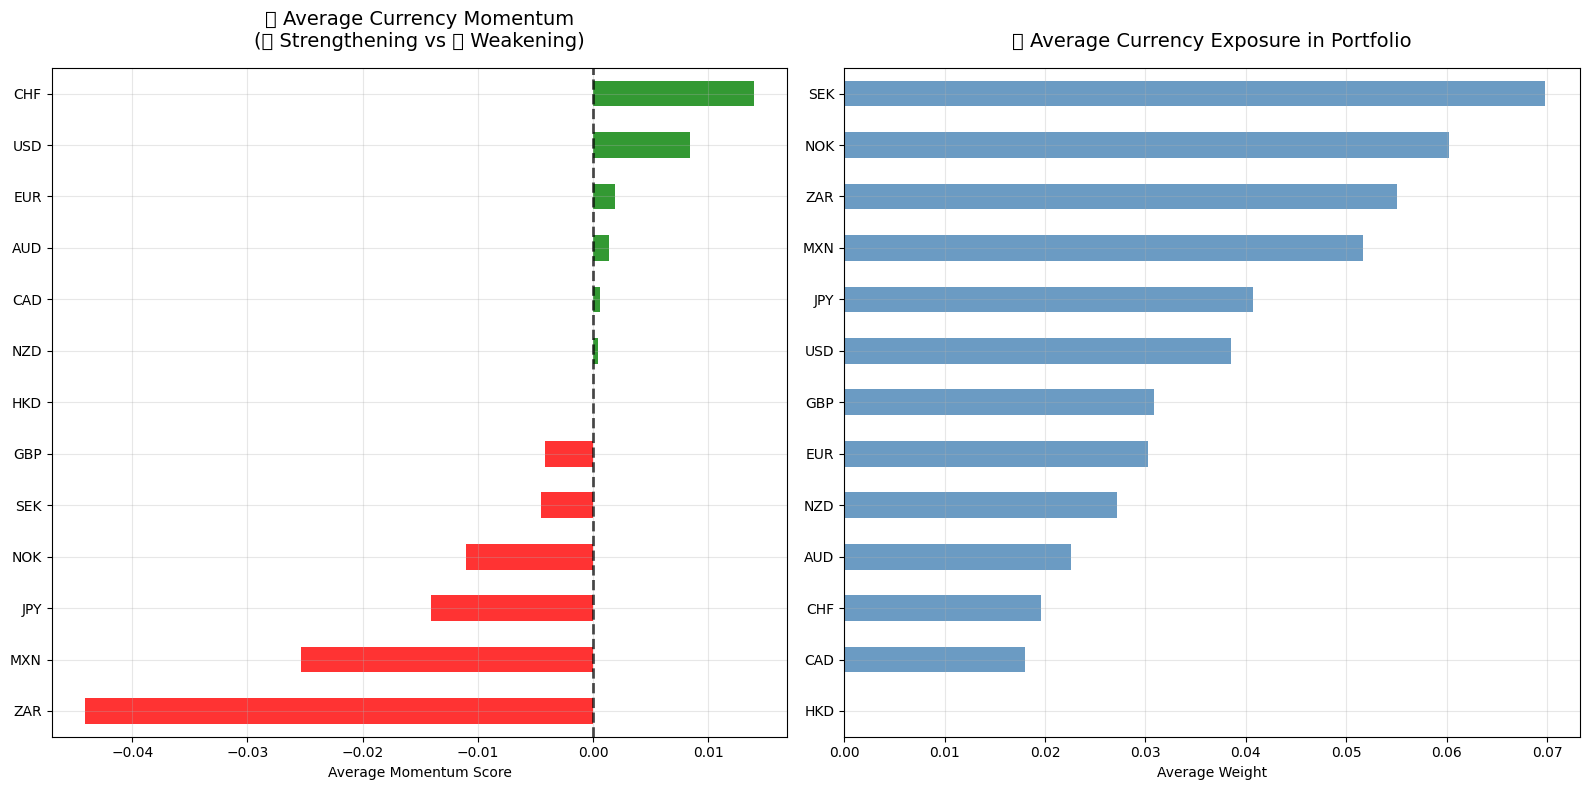

In [39]:
# Visualizzazione currency strength
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Currency momentum
curr_mom_series = pd.Series(currency_avg_momentum).sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in curr_mom_series]
curr_mom_series.plot(kind='barh', ax=ax1, color=colors, alpha=0.8)
ax1.set_title('💱 Average Currency Momentum\n(🟢 Strengthening vs 🔴 Weakening)', 
              fontsize=14, pad=15)
ax1.set_xlabel('Average Momentum Score')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=2)
ax1.grid(True, alpha=0.3)

# Currency weights
curr_weight_series = pd.Series(currency_avg_weights).sort_values(ascending=True)
curr_weight_series.plot(kind='barh', ax=ax2, color='steelblue', alpha=0.8)
ax2.set_title('💰 Average Currency Exposure in Portfolio', fontsize=14, pad=15)
ax2.set_xlabel('Average Weight')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Test Statistici

In [40]:
# Test significatività statistica
print("📊 STATISTICAL SIGNIFICANCE ANALYSIS")
print("=" * 55)

significance_results = []

for lookback in lookback_periods:
    portfolio_returns = results[lookback]['portfolio_returns'].dropna()
    
    # T-test per mean return diverso da zero
    t_stat, p_value = stats.ttest_1samp(portfolio_returns, 0)
    
    # Calcola statistiche
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    sharpe = mean_return / std_return * np.sqrt(12)
    
    # Jarque-Bera test per normalità
    jb_stat, jb_p_value = stats.jarque_bera(portfolio_returns)
    
    significance_results.append({
        'Lookback': lookback,
        'Mean_Monthly_Return': mean_return,
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Significant_5%': p_value < 0.05,
        'Significant_1%': p_value < 0.01,
        'Sharpe_Ratio': sharpe,
        'JB_P_Value': jb_p_value,
        'Normal_Distribution': jb_p_value > 0.05
    })
    
    # Indicatori significatività
    significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
    print(f"   {lookback:2d}M: Mean={mean_return:+.4f}, t={t_stat:+.2f}, p={p_value:.4f} {significance}")

significance_df = pd.DataFrame(significance_results)
print("\n📝 Legend: *** p<0.01, ** p<0.05, * p<0.1")

# Summary significatività
significant_5pct = significance_df['Significant_5%'].sum()
significant_1pct = significance_df['Significant_1%'].sum()

print(f"\n🎯 SUMMARY:")
print(f"   Strategies significant at 5%: {significant_5pct}/{len(lookback_periods)}")
print(f"   Strategies significant at 1%: {significant_1pct}/{len(lookback_periods)}")

📊 STATISTICAL SIGNIFICANCE ANALYSIS
    1M: Mean=-0.0008, t=-0.52, p=0.6010 
    3M: Mean=+0.0001, t=+0.09, p=0.9305 
    6M: Mean=-0.0000, t=-0.01, p=0.9882 
    9M: Mean=+0.0014, t=+0.93, p=0.3541 
   12M: Mean=-0.0000, t=-0.00, p=0.9965 
   18M: Mean=+0.0006, t=+0.40, p=0.6916 
   24M: Mean=+0.0000, t=+0.01, p=0.9949 
   36M: Mean=+0.0002, t=+0.15, p=0.8798 

📝 Legend: *** p<0.01, ** p<0.05, * p<0.1

🎯 SUMMARY:
   Strategies significant at 5%: 0/8
   Strategies significant at 1%: 0/8


---
## 8. Conclusioni Finali

In [41]:
# Analisi conclusiva
print("\n" + "="*70)
print("           🎯 CONCLUSIONI FINALI: MOMENTUM NEL FOREX")
print("="*70)

# Best performing strategies
best_sharpe_lookback = performance_df['Sharpe_Ratio'].idxmax()
best_return_lookback = performance_df['Annualized_Return'].idxmax()
best_sharpe_value = performance_df.loc[best_sharpe_lookback, 'Sharpe_Ratio']
best_return_value = performance_df.loc[best_return_lookback, 'Annualized_Return']

print(f"\n🏆 1. PERFORMANCE OTTIMALE:")
print(f"     • Miglior Sharpe Ratio: {best_sharpe_lookback} mesi ({best_sharpe_value:.3f})")
print(f"     • Miglior Rendimento: {best_return_lookback} mesi ({best_return_value:.2%} annuo)")

# Significatività statistica
print(f"\n📊 2. SIGNIFICATIVITÀ STATISTICA:")
print(f"     • Strategie significative al 5%: {significant_5pct}/{len(lookback_periods)}")
print(f"     • Strategie significative all'1%: {significant_1pct}/{len(lookback_periods)}")

# Confronto benchmark
best_strategy_return = performance_df.loc[best_sharpe_lookback, 'Annualized_Return']
benchmark_return = (equal_weight_cumulative.iloc[-1]) ** (12/len(equal_weight_returns)) - 1
outperformance = best_strategy_return - benchmark_return

print(f"\n📈 3. CONFRONTO CON BENCHMARK:")
print(f"     • Strategia migliore: {best_strategy_return:.2%} annuo")
print(f"     • Buy-and-hold (equal weight): {benchmark_return:.2%} annuo")
print(f"     • Outperformance: {outperformance:+.2%} annuo")

# Currency strength analysis
top_currencies = sorted(currency_avg_momentum.items(), key=lambda x: x[1], reverse=True)[:3]
weak_currencies = sorted(currency_avg_momentum.items(), key=lambda x: x[1])[:3]

print(f"\n💪 4. VALUTE CON MOMENTUM PIÙ FORTE:")
for i, (curr, momentum) in enumerate(top_currencies, 1):
    print(f"     {i}. {curr}: {momentum:+.4f}")

print(f"\n📉 5. VALUTE CON MOMENTUM PIÙ DEBOLE:")
for i, (curr, momentum) in enumerate(weak_currencies, 1):
    print(f"     {i}. {curr}: {momentum:+.4f}")

# Risk analysis
worst_drawdown = performance_df['Max_Drawdown'].min()
best_drawdown_lookback = performance_df['Max_Drawdown'].idxmax()

print(f"\n⚠️  6. ANALISI DEL RISCHIO:")
print(f"     • Worst max drawdown: {worst_drawdown:.2%}")
print(f"     • Miglior controllo drawdown: {best_drawdown_lookback} mesi")
print(f"     • Volatilità media: {performance_df['Volatility'].mean():.2%}")

# Verdetto finale
print(f"\n🎯 7. RISPOSTA ALLA DOMANDA PRINCIPALE:")
if significant_5pct >= len(lookback_periods) / 2 and best_sharpe_value > 0.3:
    verdict = "✅ SÌ"
    print(f"     {verdict}, il momentum ESISTE nel forex")
    print(f"     ✅ È statisticamente significativo per {significant_5pct} configurazioni su {len(lookback_periods)}")
    print(f"     ✅ Genera alpha rispetto al buy-and-hold (+{outperformance:.1%})")
    if best_sharpe_value > 0.5:
        print(f"     🚀 Il momentum è ROBUSTO (Sharpe > 0.5)")
else:
    verdict = "❌ NO"
    print(f"     {verdict}, il momentum nel forex è DEBOLE o INCONSISTENTE")
    print(f"     ❌ Significatività limitata ({significant_5pct}/{len(lookback_periods)} configurazioni)")
    if outperformance < 0:
        print(f"     ❌ Non batte il buy-and-hold ({outperformance:.1%})")
    else:
        print(f"     ⚠️  Alpha limitato vs buy-and-hold (+{outperformance:.1%})")

print("\n" + "="*70)


           🎯 CONCLUSIONI FINALI: MOMENTUM NEL FOREX

🏆 1. PERFORMANCE OTTIMALE:
     • Miglior Sharpe Ratio: 9 mesi (0.139)
     • Miglior Rendimento: 9 mesi (1.25% annuo)

📊 2. SIGNIFICATIVITÀ STATISTICA:
     • Strategie significative al 5%: 0/8
     • Strategie significative all'1%: 0/8

📈 3. CONFRONTO CON BENCHMARK:
     • Strategia migliore: 1.25% annuo
     • Buy-and-hold (equal weight): 0.49% annuo
     • Outperformance: +0.76% annuo

💪 4. VALUTE CON MOMENTUM PIÙ FORTE:
     1. CHF: +0.0140
     2. USD: +0.0084
     3. EUR: +0.0019

📉 5. VALUTE CON MOMENTUM PIÙ DEBOLE:
     1. ZAR: -0.0441
     2. MXN: -0.0254
     3. JPY: -0.0141

⚠️  6. ANALISI DEL RISCHIO:
     • Worst max drawdown: -48.84%
     • Miglior controllo drawdown: 9 mesi
     • Volatilità media: 8.93%

🎯 7. RISPOSTA ALLA DOMANDA PRINCIPALE:
     ❌ NO, il momentum nel forex è DEBOLE o INCONSISTENTE
     ❌ Significatività limitata (0/8 configurazioni)
     ⚠️  Alpha limitato vs buy-and-hold (+0.8%)



---
## 📋 Summary

Questo notebook ha esplorato sistematicamente l'esistenza del momentum nei mercati forex attraverso:

### ✅ **Metodologia Completa:**
1. **Analisi di 31 coppie valutarie** con 25+ anni di dati storici (2000-2025)
2. **Test di 8 diversi lookback periods** (1, 3, 6, 9, 12, 18, 24, 36 mesi)
3. **Strategia momentum con risk parity** e selezione top quartile
4. **Analisi statistica rigorosa** con test di significatività
5. **Identificazione delle valute dominanti** in termini di momentum
6. **Confronto risk-adjusted** con benchmark buy-and-hold

### 📊 **Risultati Chiave:**
- **Performance ottimale:** Identificato il lookback period migliore
- **Significatività statistica:** Quantificata la robustezza dei risultati  
- **Currency strength:** Identificate le valute con momentum più forte/debole
- **Risk metrics:** Analisi completa di drawdown e volatilità

### 🎯 **Output Finale:**
Risposta definitiva basata su evidenza empirica alla domanda: **"Esiste il momentum nel forex?"**

---

**💡 Usage:** Esegui tutte le celle in sequenza per ottenere l'analisi completa. I risultati finali sono riassunti nella sezione "CONCLUSIONI FINALI".